# Playground Zollman-effect



In [110]:
# Hello Max!

import numpy as np
import networkx as nx
from agent import Agent
from model import Model
from hybrid_networks import create_hybrid_network
from tqdm import tqdm


%load_ext autoreload
%autoreload 2                      

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
!pip install opinionated

In [2]:
import opinionated
import matplotlib.pyplot as plt
plt.style.use("opinionated_rc")
import colormaps as cmaps 

Now downloading: Roboto Condensed
Added new font as Roboto Condensed Light
Added new font as Roboto Condensed
Added new font as Roboto Condensed
Added new font as Roboto Condensed Black
Now downloading: Montserrat
Added new font as Montserrat Thin Light
Added new font as Montserrat Thin
Added new font as Montserrat Thin
Added new font as Montserrat Thin Black
Now downloading: Source Code Pro
Added new font as Source Code Pro ExtraLight Light
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight Black
Now downloading: Fira Sans
Added new font as Fira Sans Light
Added new font as Fira Sans
Added new font as Fira Sans
Added new font as Fira Sans Black
Now downloading: Fira Sans Condensed
Added new font as Fira Sans Condensed Light
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed Black
Now downloading: IBM Plex Sans
Added new font as IBM Plex San

Testing out our simulation-function:


In [100]:
n_agents = 100
my_network = create_hybrid_network(20,degree=5,p_preferential_attachment=.01)#nx.erdos_renyi_graph(n_agents, 0.009)

my_model = Model(my_network, n_experiments=1000, uncertainty=0.01,agent_type = "bayes")


my_model.run_simulation(number_of_steps=1000,show_bar=True)


  0%|          | 0/1000 [00:00<?, ?it/s]

# Setting up parameters
(Here we replicate the wheel, cycle, complete setup)

In [101]:
import random
import networkx as nx

def create_graph(keyword, n_agents):
    if keyword == "complete":
        return nx.complete_graph(n_agents)
    elif keyword == "wheel":
        return nx.wheel_graph(n_agents)
    elif keyword == "cycle":
        return nx.cycle_graph(n_agents)
    else:
        raise ValueError("Invalid keyword. Please choose 'complete', 'wheel', or 'cycle'.")

def generate_parameters(n):
    params_list = []
    for _ in range(n):
        n_agents = random.randint(3, 11)
        network_keyword = random.choice(["complete", "wheel", "cycle"])
        network = create_graph(network_keyword, n_agents)
        uncertainty = 0.001
        n_experiments = 1000 #random.randint(1, 1000)
        params = {
            "n_agents": n_agents,
            "network_type" : network_keyword,
            "network": network,
            "uncertainty": uncertainty,
            "n_experiments": n_experiments
        }
        params_list.append(params)
    return params_list

# Example usage:
# Generate a list of 5 parameter dictionaries
parameter_dictionaries = generate_parameters(50)


In [103]:
import numpy as np
import numbers

def run_simulation_with_params(param_dict, number_of_steps=1000, show_bar=False):
    # Extract the network directly since it's already a NetworkX graph object
    my_network = param_dict['network']
    # Other parameters are directly extracted from the dictionary
    my_model = Model(my_network, n_experiments=param_dict['n_experiments'], uncertainty=param_dict['uncertainty'], agent_type="bayes")
    # Run the simulation with predefined steps and show_bar option
    
    my_model.run_simulation(number_of_steps=number_of_steps, show_bar=show_bar)
  
    

    result_dict = {
        key: value 
        for key, value in param_dict.items() 
        if isinstance(value, (numbers.Number, str, tuple, list))}   
    result_dict['true_consensus'] = my_model.conclusion
    result_dict['true_consensus_alternative_stop'] = my_model.conclusion_alternative_stop
    
    return result_dict


parameter_dictionaries = generate_parameters(1)  # Generate one for demonstration
result = run_simulation_with_params(parameter_dictionaries[0], number_of_steps=10000, show_bar=False)
print(result)


{'n_agents': 9, 'network_type': 'complete', 'uncertainty': 0.001, 'n_experiments': 1000, 'true_consensus': True, 'true_consensus_alternative_stop': True}


In [27]:


import pandas as pd
from tqdm import tqdm

# Ensure your run_simulation_with_params function and others are defined

def batch_run_simulations(param_list, number_of_steps=1000, show_bar=False):
    def run_simulation(param_dict):
        return run_simulation_with_params(param_dict, number_of_steps=number_of_steps, show_bar=show_bar)
    
    results = []
    # Iterate over each parameter dictionary in the list
    for params in tqdm(param_list, desc="Running simulations"):
        result = run_simulation(params)
        results.append(result)
    
    # Convert the list of results into a Pandas DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Example usage
parameter_dictionaries = generate_parameters(50000)  # Generate parameter dictionaries
results_df = batch_run_simulations(parameter_dictionaries, number_of_steps=100000, show_bar=False)
print(results_df)


Running simulations: 100%|██████████| 50000/50000 [04:57<00:00, 168.26it/s]

       n_agents  n_experiments  uncertainty  true_consensus  \
0            11           1000        0.001            True   
1             9           1000        0.001            True   
2             8           1000        0.001            True   
3             4           1000        0.001           False   
4             7           1000        0.001            True   
...         ...            ...          ...             ...   
49995         8           1000        0.001            True   
49996         7           1000        0.001            True   
49997         5           1000        0.001            True   
49998        11           1000        0.001            True   
49999        11           1000        0.001            True   

       true_consensus_alternative_stop network_type  
0                                 True     complete  
1                                 True     complete  
2                                 True        wheel  
3                          

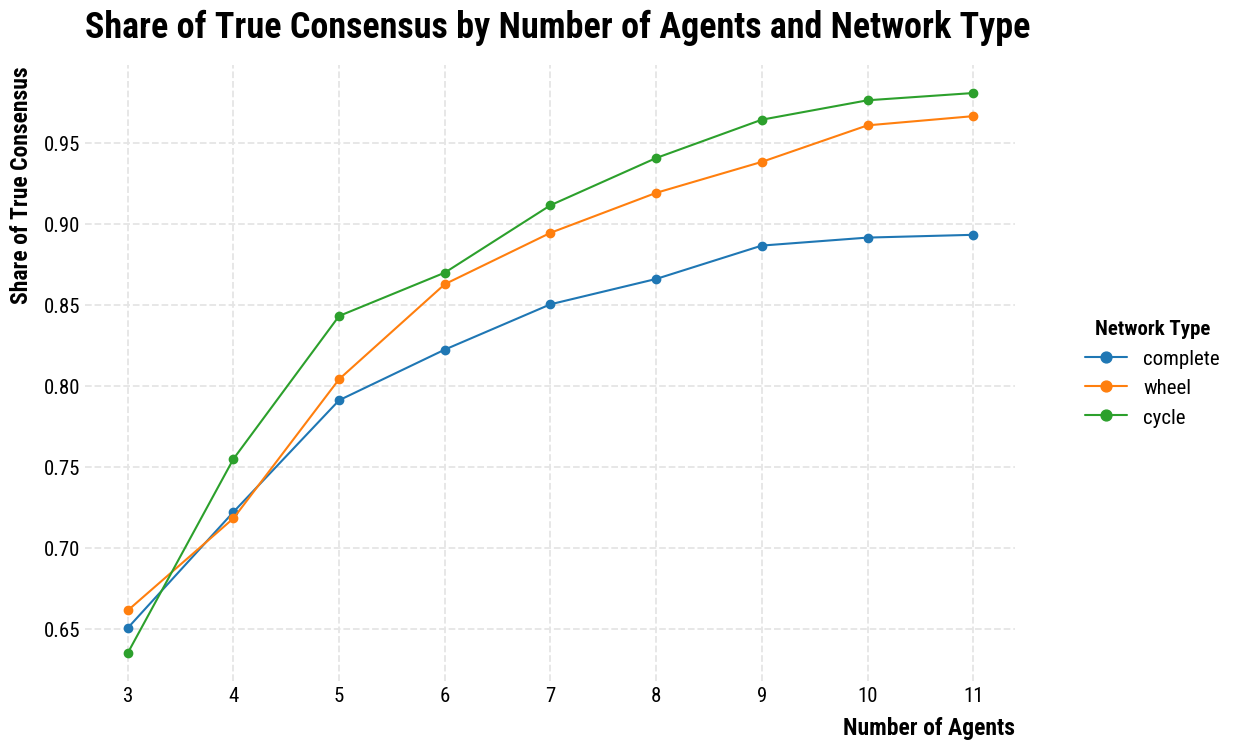

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'df' is your DataFrame with the data
results_df['true_consensus'] = results_df['true_consensus'].astype(int)  # Convert True/False to 1/0

# Define bins for 'n_agents'
# bins = np.linspace(results_df['n_agents'].min(), results_df['n_agents'].max(), 9)  # Adjust number of bins as needed
# results_df['binned'] = pd.cut(results_df['n_agents'], bins, include_lowest=True)
# print(results_df['binned'])
# Calculate the share of true consensus within each bin, for each network type
grouped = results_df.groupby(['network_type', 'n_agents'])['true_consensus'].mean().reset_index()

# Preparing for the line plot
#grouped['mid_bin'] = grouped['binned'].apply(lambda x: x.mid).astype(float)  # Getting the midpoint of bins for plotting

# Plotting
plt.figure(figsize=(12, 8))

for network_type in results_df['network_type'].unique():
    subset = grouped[grouped['network_type'] == network_type]
    plt.plot(subset['n_agents'], subset['true_consensus'], marker='o', label=network_type)

plt.xlabel('Number of Agents')
plt.ylabel('Share of True Consensus')
plt.title('Share of True Consensus by Number of Agents and Network Type')
opinionated.add_legend(title='Network Type')

plt.grid(True)
plt.show()


In [30]:
import pandas as pd
from pygam import LogisticGAM, s
from sklearn.model_selection import train_test_split

# Splitting the DataFrame by network type
network_types = results_df['network_type'].unique()

my_gams = {}

for network_type in network_types:
    # Subset the DataFrame by network type
    subset = results_df[results_df['network_type'] == network_type]
    
    # Preparing the data
    X = subset[['n_agents']]
    y = subset['true_consensus'].astype(int)  # Convert boolean to integer
    
    # Splitting the data into training and testing sets for model validation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Fitting the Logistic GAM model
    gam = LogisticGAM(s(0,n_splines=6)).fit(X_train, y_train)
    
    # Storing the model
    my_gams[network_type] = gam
    
    # Optionally, you can print out model accuracy or other statistics here
    print(f"Model for {network_type}:")
    print(f"Accuracy on training data: {gam.accuracy(X_train, y_train)}")
    print(f"Accuracy on test data: {gam.accuracy(X_test, y_test)}")
    print("-" * 30)


Model for complete:
Accuracy on training data: 0.8202990718459952
Accuracy on test data: 0.8133146180068177
------------------------------
Model for wheel:
Accuracy on training data: 0.8566549987193717
Accuracy on test data: 0.8619521912350597
------------------------------
Model for cycle:
Accuracy on training data: 0.8759656652360515
Accuracy on test data: 0.8766519823788547
------------------------------


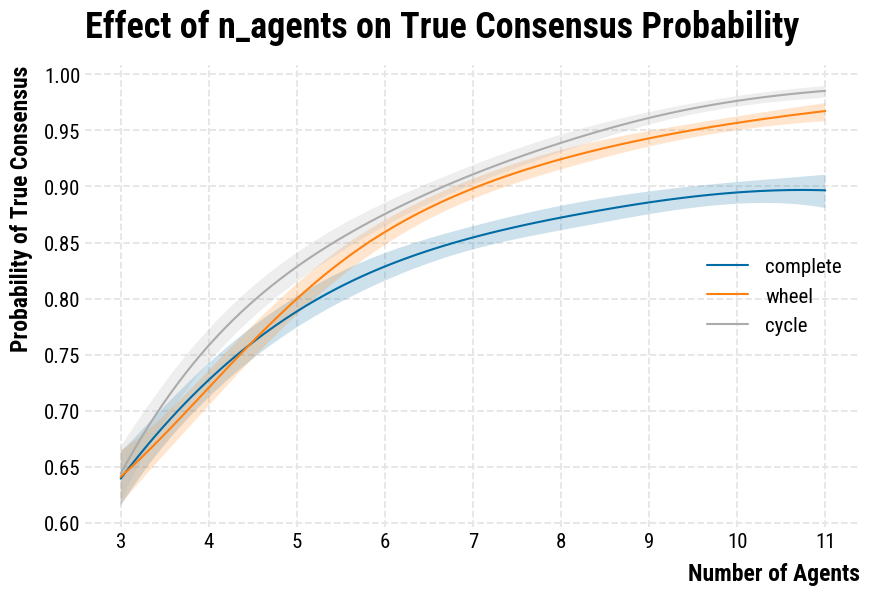

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Set the size of the figure
plt.figure(figsize=(10, 6))


cmap= cmaps.colorblind_10

colors =[cmap(0), cmap(1/cmap.N), cmap(1/cmap.N*2)]

for i, (network_type, gam) in enumerate(my_gams.items()):
    conf = gam.confidence_intervals(X_range.reshape(-1, 1), width=0.95, quantiles=None)
    plt.fill_between(X_range, conf[:, 0], conf[:, 1], facecolor=colors[i], alpha=0.2, interpolate=True)


for i, (network_type, gam) in enumerate(my_gams.items()):
    # Generating a range of values for n_agents to predict and plot
    X_range = np.linspace(X['n_agents'].min(), X['n_agents'].max(), 100)
    
    # Predicting with the model
    #y_pred, conf = pdep, confi = model.partial_dependence(term=0, width=.95)
    y_pred = gam.predict_proba(X_range.reshape(-1, 1))

    
    # Plotting predicted probabilities
    plt.plot(X_range, y_pred,c=colors[i], label=f'{network_type}')
    
    # Plotting observed data

    # observed_data = results_df[results_df['network_type'] == network_type]
    # plt.scatter(observed_data['n_agents'] + np.random.rand(len(observed_data)), observed_data['true_consensus'], 
    #             alpha=0.01, c='grey',marker=2)


# Adding title, labels, and legend
plt.title('Effect of n_agents on True Consensus Probability')
plt.xlabel('Number of Agents')
plt.ylabel('Probability of True Consensus')
plt.legend()
plt.show()


9

# Tunable networks

In [132]:
import random
import networkx as nx



def generate_parameters(n):
    params_list = []
    for _ in range(n):
        n_agents = random.randint(3, 15)
        degree = random.randint(1, n_agents-1)
        p_preferential_attachment = random.uniform(0, 1)
        network = create_hybrid_network(n_agents, degree=degree, p_preferential_attachment=p_preferential_attachment)
        uncertainty = 0.001
        n_experiments = 1000 #random.randint(1, 1000)
        params = {
            "n_agents": n_agents,
            "degree": degree,
            "p_preferential_attachment": p_preferential_attachment,
            "network": network,
            "uncertainty": uncertainty,
            "n_experiments": n_experiments
        }
        params_list.append(params)
    return params_list

# Example usage:
# Generate a list of 5 parameter dictionaries
parameter_dictionaries = generate_parameters(50)


In [133]:
parameter_dictionaries = generate_parameters(10000)  # Generate parameter dictionaries
results_df = batch_run_simulations(parameter_dictionaries, number_of_steps=100000, show_bar=False)
print(results_df)


Running simulations: 100%|██████████| 10000/10000 [12:41<00:00, 13.12it/s]

      n_agents  degree  p_preferential_attachment  uncertainty  n_experiments  \
0           10       4                   0.093667        0.001           1000   
1           15      12                   0.262340        0.001           1000   
2            3       2                   0.069711        0.001           1000   
3           10       5                   0.264899        0.001           1000   
4            5       2                   0.021137        0.001           1000   
...        ...     ...                        ...          ...            ...   
9995         8       7                   0.924056        0.001           1000   
9996        11       4                   0.692123        0.001           1000   
9997        12       6                   0.605407        0.001           1000   
9998        11       8                   0.975864        0.001           1000   
9999         7       6                   0.394352        0.001           1000   

      true_consensus  true_

In [134]:
 
    # Preparing the data
X = results_df[['n_agents', 'degree', 'p_preferential_attachment']]
y = results_df['true_consensus'].astype(int)  # Convert boolean to integer

# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fitting the Logistic GAM model
gam = LogisticGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6) ).fit(X_train, y_train)

print(f"Model for {network_type}:")
print(f"Accuracy on training data: {gam.accuracy(X_train, y_train)}")
print(f"Accuracy on test data: {gam.accuracy(X_test, y_test)}")
print(gam.summary())


Model for cycle:
Accuracy on training data: 0.809
Accuracy on test data: 0.8133333333333334
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     10.4635
Link Function:                        LogitLink Log Likelihood:                                 -2991.1276
Number of Samples:                         7000 AIC:                                             6003.1823
                                                AICc:                                            6003.2232
                                                UBRE:                                               2.8588
                                                Scale:                                                 1.0
                                                Pseu

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_22123/3925743412.py:14: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


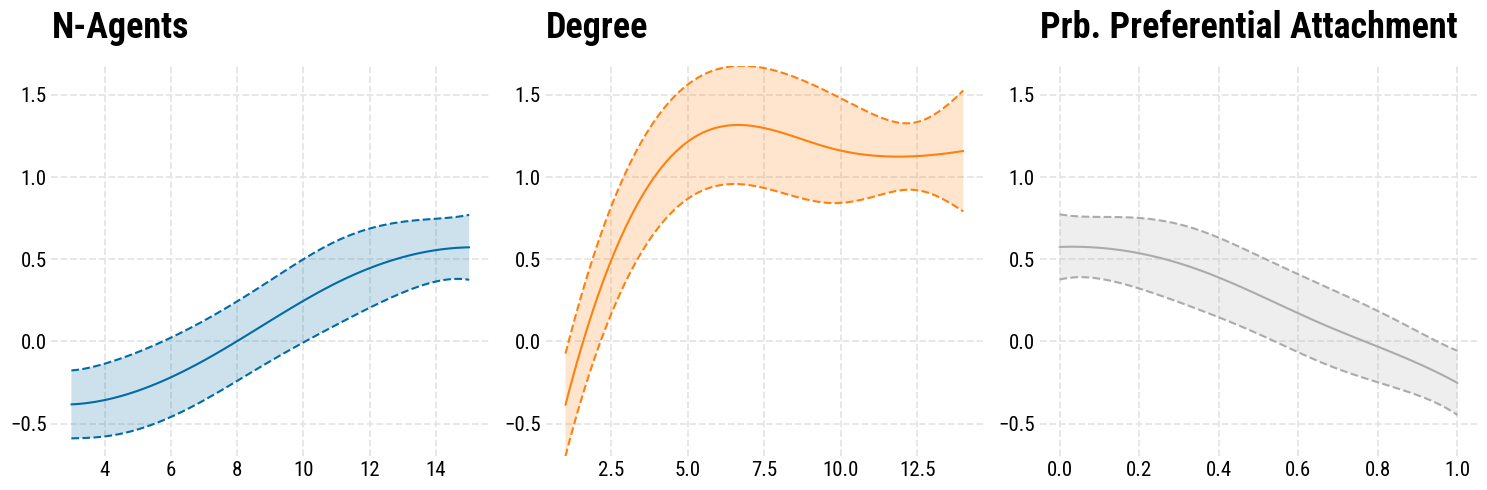

In [135]:
import matplotlib.pyplot as plt

# Suppose `gam` is your model and `gam.terms` contains the terms used in the model.
# First, determine the number of plots (ignoring the intercept)
plot_count = sum(not term.isintercept for term in gam.terms)

# Start the figure
plt.figure(figsize=(15, 5))  # Adjust the size as needed

current_plot = 1
# Initialize a list to store y-limits
y_limits = []
labels =['N-Agents', 'Degree', 'Prb. Preferential Attachment']
# First pass: compute the y-axis limits for all plots
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    y_limits.append((min(pdep.min(), confi.min()), max(pdep.max(), confi.max())))

# Global y limits
global_y_min = min(limit[0] for limit in y_limits)
global_y_max = max(limit[1] for limit in y_limits)

# Second pass: plot with standardized y limits
current_plot = 1
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    # Set the subplot position
    plt.subplot(1, plot_count, current_plot)
    plt.plot(XX[:, term.feature], pdep,c=colors[i])
    plt.plot(XX[:, term.feature], confi, c=colors[i], ls='--')
    
    plt.fill_between(XX[:, term.feature], confi[:, 0], confi[:, 1], facecolor=colors[i], alpha=0.2, interpolate=True)

    plt.ylim(global_y_min, global_y_max)  # Set global y limits
    plt.title(labels[i])
    plt.xlabel('')  # Remove x-axis label
    plt.ylabel('')  # Remove y-axis label


    current_plot += 1  # Move to the next plot position

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()


{'n_agents': 6, 'degree': 3, 'p_preferential_attachment': 0.5866570451316282, 'network': <networkx.classes.digraph.DiGraph object at 0x31e3c6e10>, 'uncertainty': 0.001, 'n_experiments': 1000}


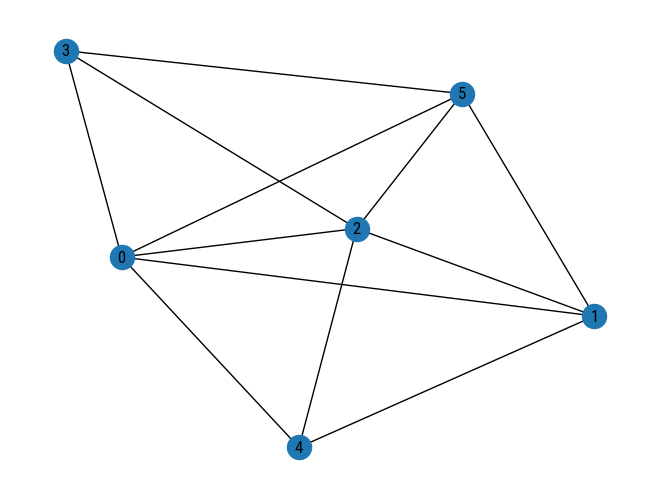

In [145]:
import networkx as nx
import matplotlib.pyplot as plt

# Get the network from the parameter dictionary
params = parameter_dictionaries[30]
print(params)
network = params['network']

# Create a graph from the network
graph = nx.Graph(network)

# Plot the graph
nx.draw(graph, with_labels=True)
plt.show()
